# Import the Libraries

In [1]:
# Standard Libraries
import re
import csv
import nltk
import spacy
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
# Visualisation Libraries
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
style.use('seaborn-poster')
from PIL import Image
from wordcloud import WordCloud
# Building classification models
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
# NLTK and Sklearn
import en_core_web_sm
from collections import Counter
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet  
from sklearn.feature_extraction.text import CountVectorizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
# Spacy
nlp = spacy.load('en')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
# Preprocessing
import en_core_web_sm
from collections import Counter
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet  
from sklearn.feature_extraction.text import CountVectorizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
# Building Models
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Model Evaulation and Scoring
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Import Data Set

In [2]:
train = pd.read_csv('../input/climate-change-edsa2020-21/train.csv')
test = pd.read_csv('../input/climate-change-edsa2020-21/test.csv')

In [3]:
train.sentiment.value_counts()
print(train.shape)
print(test.shape)

(15819, 3)
(10546, 2)


# Display data

In [4]:
display(train.head())
display(test.head())


,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


# Make a copy 

In [5]:
def update(df):
    df = train.copy()
    sentiment = df['sentiment']
    word_sentiment = []

    for i in sentiment :
        if i == 1 :
            word_sentiment.append('Pro')
        elif i == 0 :
            word_sentiment.append('Neutral')
        elif i == -1 :
            word_sentiment.append('Anti')
        else :
            word_sentiment.append('News')

    df['sentiment'] = word_sentiment
    
    return df

df = update(train)
df.head()
    


,sentiment,message,tweetid
0,Pro,PolySciMajor EPA chief doesn't think carbon di...,625221
1,Pro,It's not like we lack evidence of anthropogeni...,126103
2,News,RT @RawStory: Researchers say we have three ye...,698562
3,Pro,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,Pro,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


# Clean up the Tweet Data

In [6]:
def TweetClean(tweet):
    
    # Remove hashtags from the tweet
    tweet = re.sub(r'#\w*', '', tweet) 
    
    # Convert all text to lowercase
    tweet = tweet.lower()
    
    # Remove url's that appear in the tweets
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet) 
    
    # Remove mentions in the tweet
    tweet = re.sub('@[\w]*','',tweet)  
    
    # Remove any numbers that appear in the tweet
    tweet = re.sub(r'\d+', '', tweet) 
    
    # Remove blackspace from the tweet
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
    # Remove any punctuation from the Tweet
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', tweet) 
    
    # Remove strange characters from tweet
    tweet = re.sub(r"U+FFFD ", ' ', tweet) 
        
    # Remove blank spaces in front of tweet  
    tweet = tweet.lstrip(' ') 
    
    return tweet
# Clean the tweets in the message column

df['message'] = df['message'].apply(TweetClean)
df['message'] = df['message'].apply(TweetClean)

df.head()



,sentiment,message,tweetid
0,Pro,polyscimajor epa chief doesn t think carbon di...,625221
1,Pro,it s not like we lack evidence of anthropogeni...,126103
2,News,rt researchers say we have three years to act ...,698562
3,Pro,wired was a pivotal year in the war on climate...,573736
4,Pro,rt it s and a racist sexist climate change den...,466954


# Speech Tag and Lemmetization

In [7]:
def lem(df):
    df['length'] = df['message'].str.len()
    df['tokenized'] = df['message'].apply(word_tokenize)
    df['pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)

def get_wordnet_position(tag):
    if tag.startswith('J'):
        return wordnet.ADJ

    elif tag.startswith('V'):
        return wordnet.VERB

    elif tag.startswith('N'):
          return wordnet.NOUN

    elif tag.startswith('R'):
          return wordnet.ADV
        
    else:
        return wordnet.NOUN
        
    wl = WordNetLemmatizer()
    df['pos_tags'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    df['lemmatized'] = df['pos_tags'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
    df['lemmatized'] = [' '.join(map(str, l)) for l in df['lemmatized']]  
    return df

df = lem(df)


# Splitting the X variable from Target 

In [8]:
X = train['message']
y = train['sentiment']


# Creaion of Validation Set

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

# Vectorization and Fitting methods

In [10]:
# 1. Random Forest:

rf = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', RandomForestClassifier(max_depth=5, 
                                              n_estimators=100))])

# 2. Naïve Bayes:

nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB())])


# 3. Linear SVC:

lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC(class_weight='balanced'))])

# Fit the models that have been chosen for the challenge
# 1. Random Forest 

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)

# 2. Naive Bayes

nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_valid)

# 3. Linear SVC

lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_valid)


# Outout Random Forest Model

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       336
           0       0.00      0.00      0.00       547
           1       0.55      1.00      0.71      2178
           2       0.00      0.00      0.00       894

    accuracy                           0.55      3955
   macro avg       0.14      0.25      0.18      3955
weighted avg       0.30      0.55      0.39      3955



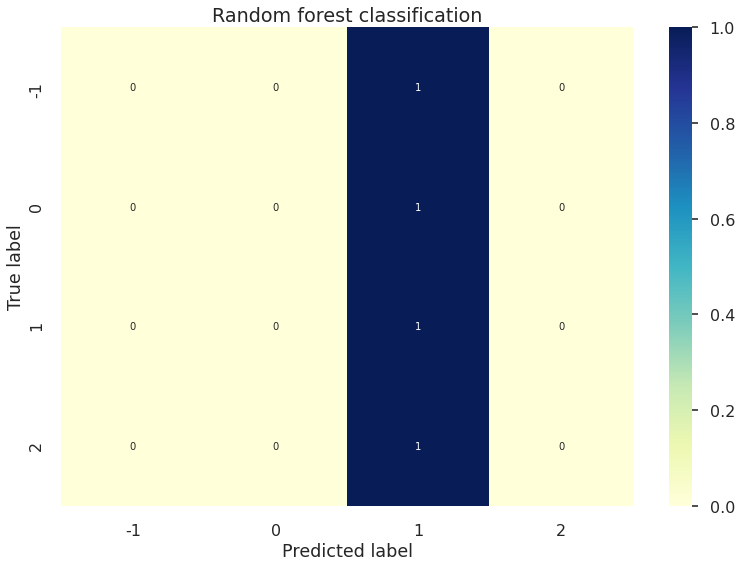

In [11]:
# Output Classification Report, Random Forest

print(metrics.classification_report(y_valid, y_pred_rf))

# Normalized Confusion Matrix

cm = confusion_matrix(y_valid, y_pred_rf)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display as a Heatmap

sns.heatmap(cm_norm, 
            cmap="YlGnBu", 
            xticklabels=rf.classes_, 
            yticklabels=rf.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

# Adding headings and lables
plt.title('Random forest classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# Visualise the Output from Naive Bayes Model

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       336
           0       1.00      0.05      0.09       547
           1       0.60      0.99      0.75      2178
           2       0.94      0.33      0.48       894

    accuracy                           0.63      3955
   macro avg       0.63      0.34      0.33      3955
weighted avg       0.68      0.63      0.53      3955



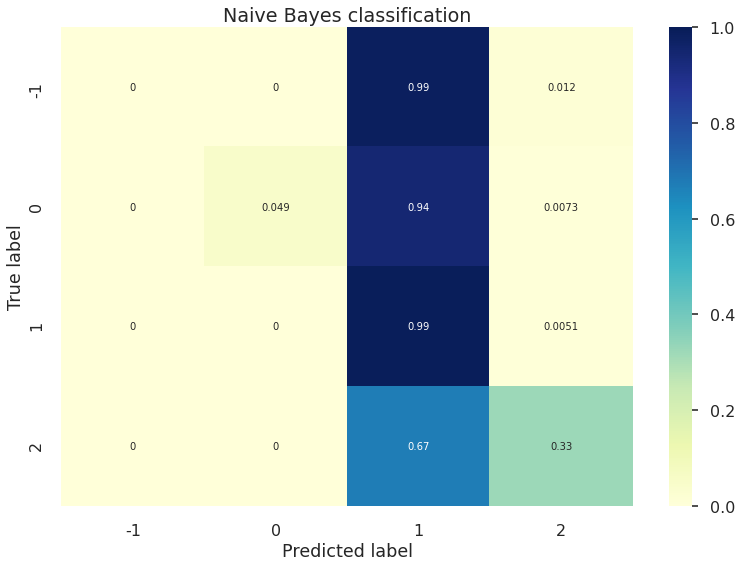

In [12]:
# Classification Report for the Naive Bayes model

print(metrics.classification_report(y_valid, y_pred_nb))

# Normalized Confusion Matrix

cm = confusion_matrix(y_valid, y_pred_nb)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display Heatmap

sns.heatmap(cm_norm, 
            cmap="YlGnBu", 
            xticklabels=nb.classes_, 
            yticklabels=nb.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

plt.title('Naive Bayes classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



# Hyperparameter Tuning on Linear CSV Model#

In [13]:
# Retrain linear SVC using hyperparameters:

linsvc_op = Pipeline([('tfidf', TfidfVectorizer(max_df=0.8,
                                                    min_df=2,
                                                    ngram_range=(1,2))),
                  ('clf', LinearSVC(C=0.3,
                                    class_weight='balanced',
                                    max_iter=3000))])

# Fit and predict
linsvc_op.fit(X_train, y_train)
y_pred = linsvc_op.predict(X_valid)

print('F1 score improved by',
      round(100*((metrics.accuracy_score(y_pred, y_valid) - metrics.accuracy_score(y_pred_lsvc, y_valid)) /metrics.accuracy_score(y_pred_lsvc, y_valid)),0), 
      '%')


F1 score improved by 2.0 %


# CSV Output Submission

In [14]:
y_test = linsvc_op.predict(test['message'])
output = pd.DataFrame({'tweetid': test.tweetid,
                       'sentiment': y_test})
output.to_csv('testsubmission.csv', index=False)
output

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,-1
10542,875167,1
10543,78329,2
10544,867455,0
